In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')

STOPWORDS = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

In [2]:
def preprocess(text_array):
    preprocessed_text = [" ".join([stemmer.stem(lemmatizer.lemmatize(t)) for t in text.split()]) for text in text_array]
    return preprocessed_text

def generate_wordcloud(text):
    text_to_generate = text
    if type(text) == list:
        text_to_generate = " ".join([" ".join(i) for i in text]) if type(text[0]) == list else " ".join(text)
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white').generate(text_to_generate)
    plt.figure(figsize = (13.8, 6))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    
def get_bag_of_words(text, tf_idf = False, params = None):
    vectorizer = CountVectorizer(**params) if not tf_idf else TfidfVectorizer(**params)
    corpus = vectorizer.fit_transform(text)
    return vectorizer, corpus
    
def fit_clustering_methods(corpus, params, kMeans = True):
    classifier = KMeans(**params) if kMeans else AgglomerativeClustering(**params)
    labels = classifier.fit_predict(corpus.toarray())
    return classifier, labels

def visualize_cluster_bag_words(num_cluster, corpus, labels, vectorizer, recursive_group = 0):
    for i in range(num_cluster):
        print("Group {}-{}".format(recursive_group, i+1))
        label_corpus = corpus[np.where(labels == i)]
        print("Size:  ", label_corpus.shape[0])
        try:
            generate_wordcloud(" ".join(np.char.join(' ', vectorizer.inverse_transform(corpus[np.where(labels == i)]))))
        except TypeError as e:
            generate_wordcloud(" ".join([i[0] for i in np.char.join('', vectorizer.inverse_transform(corpus[np.where(labels == i)]))
                                        if len(i) >= 1])) 
            
def unsupervised_checking(text_array, tf_idf = False, kMeans = True, recursive = False, recursive_group = 0,
                          vectorizer_params = None, clustering_params = None):
    num_cluster = clustering_params["n_clusters"]
    vectorizer, corpus = get_bag_of_words(text_array, tf_idf = tf_idf, params = vectorizer_params)
    classifier, labels = fit_clustering_methods(corpus, clustering_params, kMeans = kMeans)
    visualize_cluster_bag_words(num_cluster, corpus, labels, vectorizer, recursive_group = recursive_group)
    group_size = sorted([(i, corpus[np.where(labels == i)].shape[0]) for i in range(num_cluster)], 
                         key = lambda x: x[1], reverse = True)
    if group_size[0][1] > 2 * group_size[1][1] and recursive:
        recursive_group += 1
        print('\nRecursive on group {}\n'.format(group_size[0][0] + 1))
        _ = unsupervised_checking([text_array[i] for i in np.where(labels == group_size[0][0])[0]], 
                                  tf_idf = tf_idf, kMeans = KMeans, recursive = recursive, recursive_group = recursive_group,
                                  vectorizer_params = vectorizer_params, clustering_params = clustering_params)
    return classifier
                                       

In [3]:
df = pd.read_csv("../data/open_ended_responses.csv")

# Other activities

In [4]:
oact_col_names = [c for c in df.columns if "oact" in c and "compx" not in c]
oact = [act for c in oact_col_names for act in df[df[c].notnull()].loc[1:, c]]
preprocessed_oact = preprocess(oact)

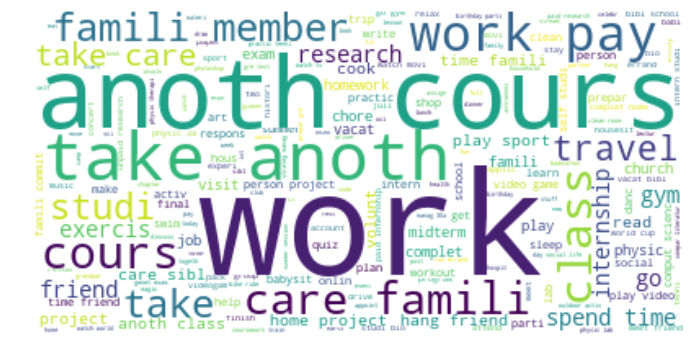

In [6]:
generate_wordcloud(preprocessed_oact)

Group 0-1
Size:   2044


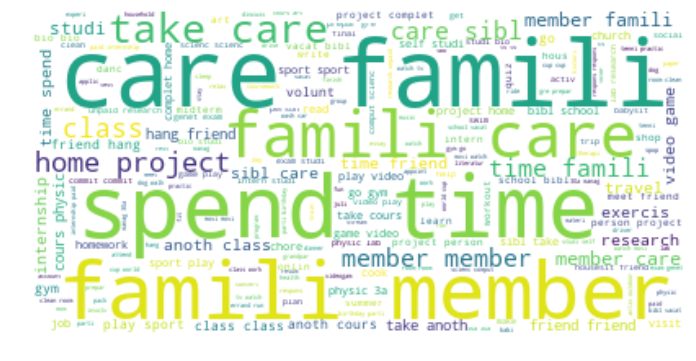

Group 0-2
Size:   132


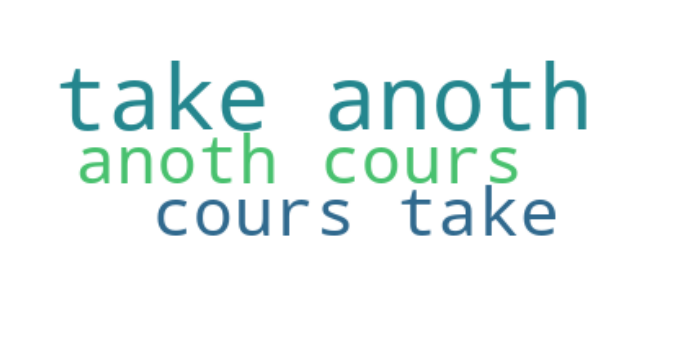

Group 0-3
Size:   117


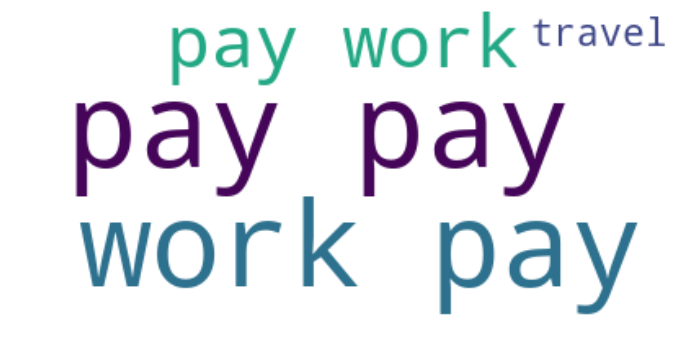

In [7]:
vectorizer_params = {"min_df": 5, "max_df": 150, "lowercase": True, "stop_words": STOPWORDS, "ngram_range": (1, 4)}
clustering_params = {"n_clusters": 3}
classifier = unsupervised_checking(preprocessed_oact, tf_idf = True, kMeans = True,
                                   vectorizer_params = vectorizer_params, clustering_params = clustering_params)

Group 0-1
Size:   2043


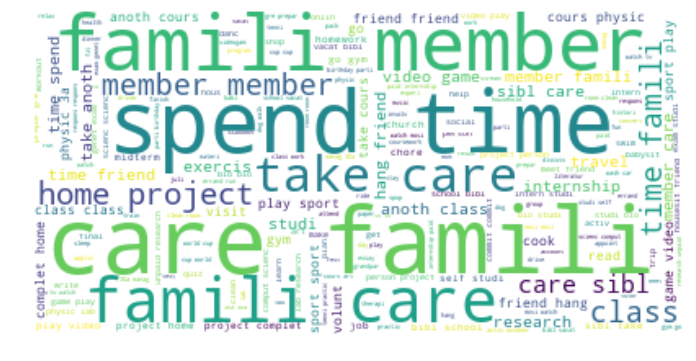

Group 0-2
Size:   132


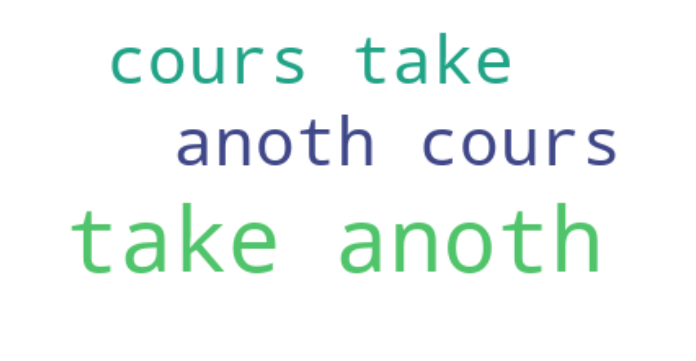

Group 0-3
Size:   118


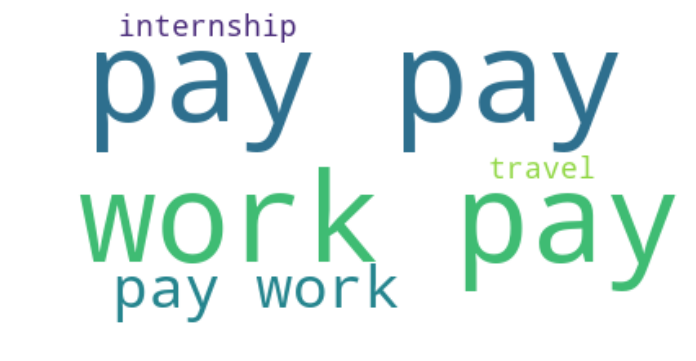

In [8]:
clustering_params = {"n_clusters": 3}
classifier = unsupervised_checking(preprocessed_oact, tf_idf =True, kMeans = False,
                      vectorizer_params = vectorizer_params, clustering_params = clustering_params)

## Other activities could be separated into "Personal (family, workout)", "another Class", "Work"

# Course-related activities

In [9]:
cact_col_names = ["dcact{}".format(i) for i in range(1, 31)]
cact = [act for c in cact_col_names for act in df[df[c].notnull()].loc[1:, c]]
preprocessed_cact = preprocess(cact)

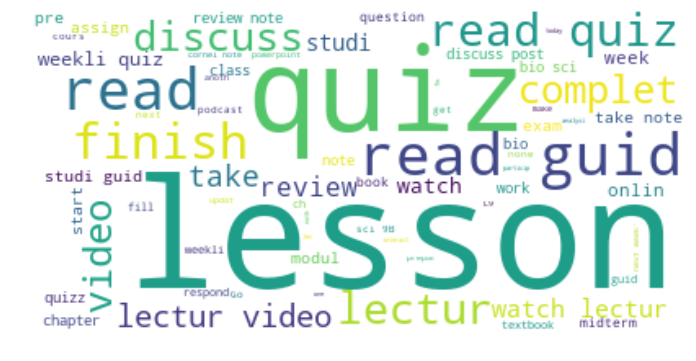

In [10]:
generate_wordcloud(preprocessed_cact)

Group 0-1
Size:   118


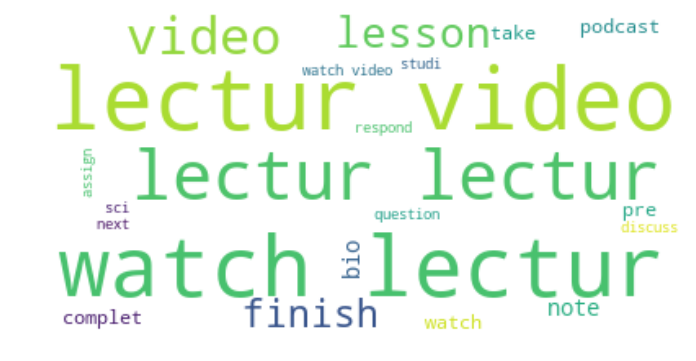

Group 0-2
Size:   571


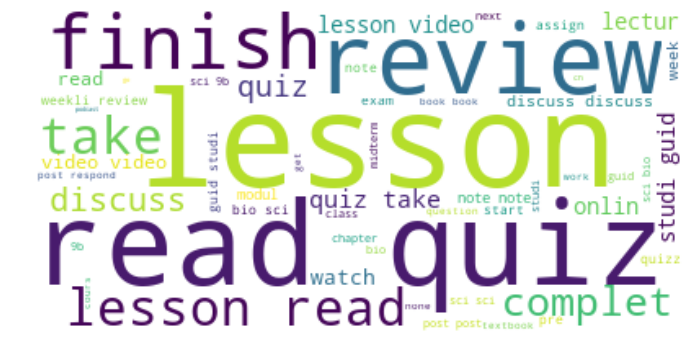

Group 0-3
Size:   94


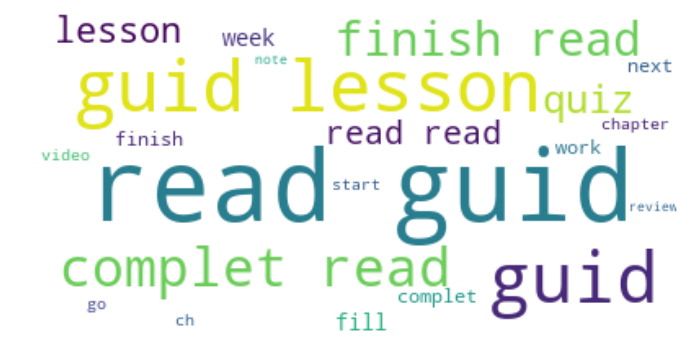

Group 0-4
Size:   22


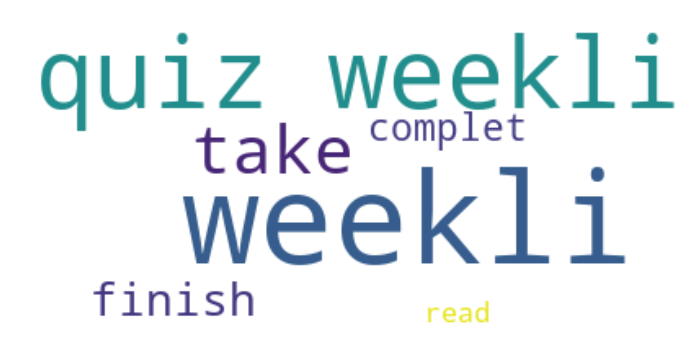

In [20]:
vectorizer_params = {"min_df": 5, "max_df": 150, "lowercase": True, "stop_words": STOPWORDS, "ngram_range": (1, 4)}
clustering_params = {"n_clusters": 4}
classifier = unsupervised_checking(preprocessed_cact, tf_idf = True, kMeans = True,
                                   vectorizer_params = vectorizer_params, clustering_params = clustering_params)

Group 0-1
Size:   124


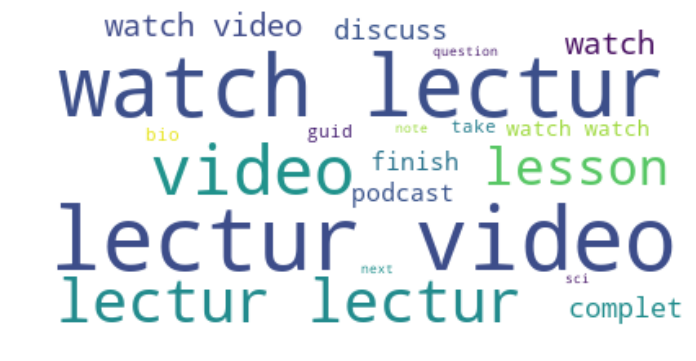

Group 0-2
Size:   608


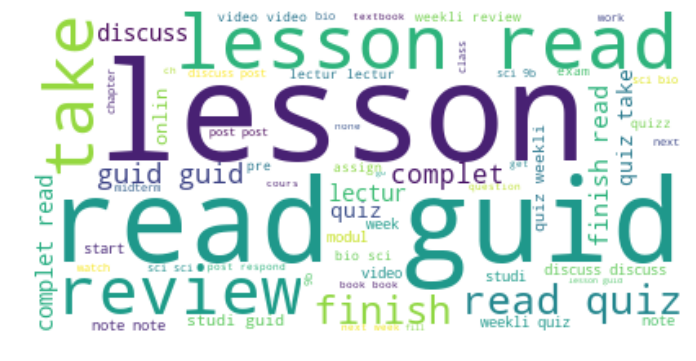

Group 0-3
Size:   44


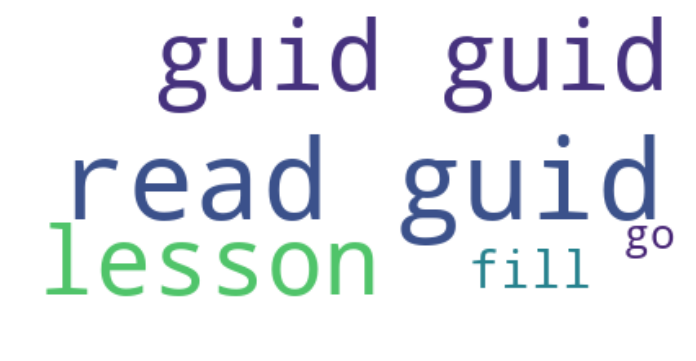

Group 0-4
Size:   29


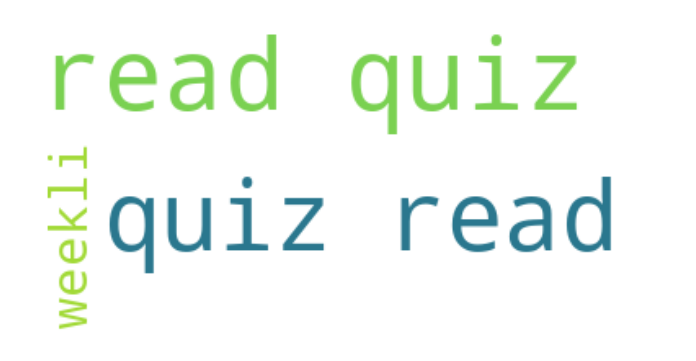

In [21]:
classifier = unsupervised_checking(preprocessed_cact, tf_idf = True, kMeans = False,
                                   vectorizer_params = vectorizer_params, clustering_params = clustering_params)

## Course-related activities could be categorized into "quiz", "guide", "lecture vedio" and "general materials"